<a href="https://colab.research.google.com/github/ThrupthiAnn/SummerSchool2021_HandsOn_Aug7/blob/main/GAN/01_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Module 1: Generative Adversarial Networks

In this lab, we will explore several architectures of generative adversarial networks. There are many different versions of GANs existing today. 

![](https://github.com/ThrupthiAnn/CVSummerSchool2021/blob/main/GAN/Gans.jpg?raw=1)

The break-up for today's lab is as follows:
<ol>
<li>Vanilla GAN (DCGAN)</li>
<li>Conditional GAN (CGAN)</li>
<li>Auxiliary Classifier GAN (AC-GAN) </li>
<li>Bi-directional GAN (BiGAN) </li>
</ol>

These codes are modified from https://github.com/wiseodd/generative-models/tree/master/GAN

## Module 1: Vanilla GAN (using DCGANs)

Let us first look at a normal generative adversarial network. 

First, let us define some constants and import some libraries. We also define a custom weights initialization function.

(Read later about Xavier initialization: http://andyljones.tumblr.com/post/110998971763/an-explanation-of-xavier-initialization)
(Link to paper: https://arxiv.org/abs/1406.2661)


In [ ]:
import torch
import torch.nn.functional as nn
import torch.autograd as autograd
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import os
from torch.autograd import Variable

%matplotlib inline

mb_size = 64
Z_dim = 100
X_dim = 784
y_dim = 10
h_dim = 128
c = 0
lr = 1e-3

def xavier_init(size):
    in_dim = size[0]
    xavier_stddev = 1. / np.sqrt(in_dim / 2.)
    vec = torch.randn(*size) * xavier_stddev
    if setcuda:
        vec = vec.cuda()
    return Variable(vec, requires_grad=True)

setcuda = True


We are using MNIST dataset for these experiments. Let us load the dataset. We will also define some functions that will be used for the other modules of this lab. Note that we are flattening the MNIST images into one dimensional vectors. 


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw




Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw




Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw




Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


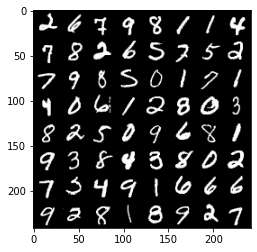

In [ ]:
import torchvision
import torchvision.transforms as transforms

# load the dataset
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0,), (1,))])
trainset = torchvision.datasets.MNIST(root='./data/', train=True,
                                        download=True,transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=mb_size,
                                          shuffle=True, num_workers=2)
classes = ('0','1','2','3','4','5','6','7','8','9')

def onehotencoder(x):
    y = np.zeros((x.numpy().shape[0],10))
    for i in range(x.numpy().shape[0]):
        y[i,x[i]] = 1
    return y

dataiter = iter(trainloader)
dataiter = iter(trainloader)
images, labels = dataiter.next()

def mnist_next(dataiter):

    try:
        images, labels = dataiter.next()
        labels = onehotencoder(labels)
        images = images.view(images.numpy().shape[0],28*28)
    except:
        dataiter = iter(trainloader)
        images, labels = dataiter.next()
        labels = onehotencoder(labels)
        images = images.view(images.numpy().shape[0],28*28)
    return images.numpy(), labels

def initialize_loader(trainset):
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=mb_size,
                                          shuffle=True, num_workers=2)
    dataiter = iter(trainloader)
    return dataiter

images, labels = mnist_next(dataiter)
# print some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()
img = torchvision.utils.make_grid(images)
npimg = img.numpy()
plt.imshow(np.transpose(npimg, (1, 2, 0)))
plt.show()

Now, let us define the network structure. For this experiment, we are not using deep networks. We are not even using torch.nn layers. Instead, we will use simple linear fully connected layers. The generator and discriminators are 2-layer networks. This is why we flattened the images in the block above.

In [ ]:
""" ==================== GENERATOR ======================== """

Wzh = xavier_init(size=[Z_dim, h_dim])
Whx = xavier_init(size=[h_dim, X_dim])
bzvar = torch.zeros(h_dim);
bhvar = torch.zeros(X_dim);
if setcuda:
    bzvar = bzvar.cuda()
    bhvar = bhvar.cuda()
    
bzh = Variable(bzvar, requires_grad=True)
bhx = Variable(bhvar, requires_grad=True)

def G(z):
    h = nn.relu(torch.mm(z, Wzh) + bzh.repeat(z.size(0), 1))
    X = torch.sigmoid(torch.mm(h, Whx) + bhx.repeat(h.size(0), 1))
    return X

In [ ]:
""" ==================== DISCRIMINATOR ======================== """

Wxh = xavier_init(size=[X_dim, h_dim])
Why = xavier_init(size=[h_dim, 1])
bxvar = torch.zeros(h_dim)
bhvar = torch.zeros(1)

if setcuda:
    bxvar = bxvar.cuda()
    bhvar = bhvar.cuda()
    
bxh = Variable(bxvar, requires_grad=True)
bhy = Variable(bhvar, requires_grad=True)

def D(X):
    h = nn.relu(torch.mm(X, Wxh) + bxh.repeat(X.size(0), 1))
    y = torch.sigmoid(torch.mm(h, Why) + bhy.repeat(h.size(0), 1))
    return y

Here, we will gather the parameters of the generator and the discriminator so that they can be given to the Adam optimizer to update the weights


In [ ]:
G_params = [Wzh, bzh, Whx, bhx]
D_params = [Wxh, bxh, Why, bhy]
params = G_params + D_params

""" ===================== TRAINING ======================== """


def reset_grad():
    for p in params:
        p.grad.data.zero_()


G_solver = optim.Adam(G_params, lr=1e-3)
D_solver = optim.Adam(D_params, lr=1e-3)

ones_label = Variable(torch.ones(mb_size))
zeros_label = Variable(torch.zeros(mb_size))

if setcuda:
    ones_label = ones_label.cuda()
    zeros_label = zeros_label.cuda()

Now, we will start the actual training. The training alternates between updating the discriminator network's weights and updating the generator's weight.

First, we update the discriminator's weight. We take a minibatch from the dataset and do a forward pass on the discriminator with the label '1'. Then, we feed noise into the generator and feed the generated images into the discriminator with the label '0'. We backpropagate the error and update the discriminator weights. 

To update the generator weights, we feed noise to the generator and feed the generated images into the discriminator with the label '1'. This error is backpropagated to update teh weights of G.

In [ ]:
dataiter = initialize_loader(trainset)

for it in range(1000):
    # Sample data
    z = Variable(torch.randn(mb_size, Z_dim))
    X, _ = mnist_next(dataiter)
    if X.shape[0]!=mb_size:
        dataiter = initialize_loader(trainset)
        X,_ = mnist_next(dataiter)
    X = Variable(torch.from_numpy(X))
    
    if setcuda:
        X = X.cuda()
        z = z.cuda()

    # Dicriminator forward-loss-backward-update
    G_sample = G(z)
    D_real = D(X)
    D_fake = D(G_sample)

    D_loss_real = nn.binary_cross_entropy(D_real.squeeze(1), ones_label)
    D_loss_fake = nn.binary_cross_entropy(D_fake.squeeze(1), zeros_label)
    D_loss = D_loss_real + D_loss_fake

    D_loss.backward()
    D_solver.step()

    # Housekeeping - reset gradient
    reset_grad()

    # Generator forward-loss-backward-update
    if setcuda:
        z = Variable(torch.randn(mb_size, Z_dim).cuda())
    else:
        z = Variable(torch.randn(mb_size, Z_dim))
    G_sample = G(z)
    D_fake = D(G_sample)

    G_loss = nn.binary_cross_entropy(D_fake.squeeze(1), ones_label)

    G_loss.backward()
    G_solver.step()

    # Housekeeping - reset gradient
    reset_grad()

    # Print and plot every now and then
    if it % 1000 == 0:
        print('Iter-{}; D_loss: {}; G_loss: {}'.format(it, D_loss.data.cpu().numpy(), G_loss.data.cpu().numpy()))

Iter-0; D_loss: 1.38315749168396; G_loss: 0.9795893430709839


Let us see the images generated by the generator:

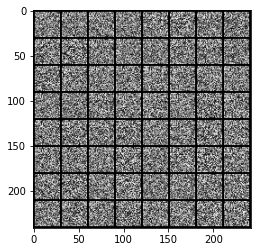

In [ ]:
z = Variable(torch.randn(mb_size, Z_dim))
if setcuda:
    z = z.cuda()
samples = G(z)
samples = samples.cpu()
img = samples.data
img = img.view([64,1,28,28])
img = torchvision.utils.make_grid(img)
img = img.permute(1,2,0)
plt.imshow(img.numpy())

### Questions/Exercises
<ol>
<li> How long do we have to train the GAN to get good results? Can you plot the loss of the generator and discriminator and see if there is a correlation?</li>
<li> What is the correlation between the input random noise and the output produced by the generator? Can you vary the input noise a little and see the result on the generated images? </li>
<li> Is there any way to determine the class of the generated images by changing the input noise vector?</li>
</ol>